## 다른 Calibration Tech 이용


- 보정용 network 생성

In [1]:
import pandas as pd
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2

In [5]:
Thickness = pd.read_csv('./data/Thickness.csv')
Thickness = Thickness.drop([33]) # 9-1 drop
Thickness.reset_index(drop=True, inplace=True)

(100, 50, 3)


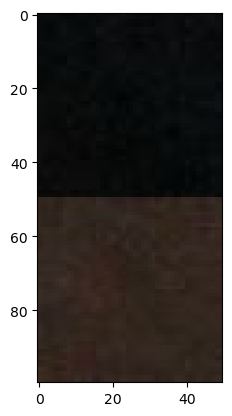

In [33]:
# 참조용 object 이미지와 촬영 대상 이미지의 경로
target_path_list = [f'./data/box_img/Top/Top_{i}.jpg' for i in range(0, 127)]
ref_path_list = [f'./data/box_img/Bot/Bot_{i}.jpg' for i in range(0, 127)]
concat_path_list = [f'./data/box_img/concat/concat_{i}.jpg' for i in range(0, 127)]

for i in range(0, 127):
    target_img = cv2.imread(target_path_list[i])
    ref_img = cv2.imread(ref_path_list[i])
    concat_img = cv2.vconcat([target_img, ref_img])
    cv2.imwrite(concat_path_list[i], concat_img)
    
# show sample image

img = cv2.imread(concat_path_list[0])
plt.imshow(img)
print(img.shape)

In [82]:
class CorrectionNet(nn.Module):
    def __init__(self):
        super(CorrectionNet, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
                                    nn.MaxPool2d(kernel_size = 2, stride = 2),nn.ReLU())
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
                                    nn.MaxPool2d(kernel_size = 2, stride = 2),nn.ReLU())
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear1 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(p=0.2)
        self.linear2 = nn.Linear(64, 1)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)시킵니다. 
        out = self.linear1(out)
        out = self.dropout(out)
        out = self.linear2(out)
        return out
    
class CustomDataset(Dataset):
    def __init__(self, path_list, transform=None):
        self.path_list = path_list
        self.transform = transform
    def __len__(self):
        return len(self.path_list)
    def __getitem__(self, idx):
        image = Image.open(self.path_list[idx])
        if self.transform:
            image = self.transform(image)
        return image, Thickness['Thickness'][idx]
    
transform = transforms.Compose([torchvision.transforms.ToTensor()])

In [83]:
test_index = pd.read_csv("./data/test_index.csv")
test_index = test_index['test_index'].tolist()
train_index = [i for i in range(0, 127) if i not in test_index]

In [95]:
dataset = CustomDataset(concat_path_list, transform=transform)

train_dataset = torch.utils.data.Subset(dataset, train_index)
test_dataset = torch.utils.data.Subset(dataset, test_index)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [93]:
model = CorrectionNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

def train(model, EPOCHS, train_dataloader, optimizer, criterion):
    model.train()
    train_loss = 0
    for epoch in range(EPOCHS):
        for batch_idx, (data, target) in enumerate(train_dataloader):
            target = target.float()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            
            optimizer.step()
            train_loss += loss.item()
        if epoch % 10 == 0:
            print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()/len(train_dataloader.dataset)))
        
def test(model, test_dataloader, criterion):
    model.eval()
    test_loss = 0
    pred_list = []
    total = 0
    
    with torch.no_grad():
        for data, target in test_dataloader:
            output = model(data)
            pred_list.append(output.item())
            loss = criterion(output, target)
            test_loss += loss.item()
            total += 1
    print('Test set: Average loss: {:.4f}'.format(test_loss/total))
    return pred_list


In [97]:
EPOCHS = 200
train(model, EPOCHS, train_dataloader, optimizer, criterion)

Train Epoch: 0 	Loss: 1686.809692
Train Epoch: 10 	Loss: 118.979485
Train Epoch: 20 	Loss: 216.732376


KeyboardInterrupt: 

In [98]:
y_pred = test(model, test_dataloader, criterion)
y_test = Thickness['Thickness'][test_index].tolist()

c:\Users\se99a\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test set: Average loss: 571.9184


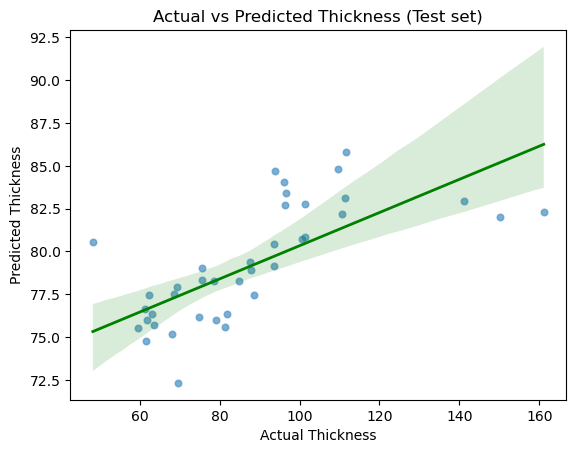

In [99]:
import statsmodels.api as sm
import seaborn as sns

# 그래프 그리기
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s': 20, 'alpha':0.3}, line_kws={'color':'green', 'linewidth': 2}, robust=True)

plt.xlabel('Actual Thickness')
plt.ylabel('Predicted Thickness')
plt.title('Actual vs Predicted Thickness (Test set)')
plt.show()

In [100]:
pd.DataFrame({'True': y_test, 'Predict': y_pred})

,True,Predict
0,75.533333,78.307465
1,61.300000,76.617882
2,68.700000,77.520531
3,96.633333,83.400932
4,101.466667,80.831207
5,63.166667,76.329697
6,69.433333,77.940918
7,96.266667,82.720070
8,61.466667,74.755882
9,111.533333,85.803368


In [101]:
from sklearn.metrics import mean_squared_error
# 테스트 세트에서의 RMSE 계산
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('MSE: {0:.3f}, RMSE: {1:.3f}'.format(mse, rmse))

MSE: 571.918, RMSE: 23.915
